`Auto Regressive` models learn from past values and it can take a while for AR mmodels to adjust for sudden shocks in data. `Moving Average` models learn from `past mistakes` i.e., learn from past errors/residuals. SO `MA` models perform well in predicting `Random Walk Data`.  

Moving Average Model `MA Model` is a linera model where current period values are a sum of past errors multiplied by a numeric factor (The numeric factor should be between -1 and +1 to maintain stability). It learns from `past errors` instead of past values like AR Models.

Current value = [Past residual * Numeric Factor] + Constant + current residual.

`MA(1) Model` uses only one past resudual i.e., the past 1 error.

`MA(2) Model` uses previous resudual and previous to previous resudual i.e., past 2 errors.

**Note:**  With some restriction, AR model and MA Model are equated as below  
        AR(1)   ≈ MA(inf)  
        AR(inf) ≈ MA(1)  
        
[Proof for AR(1)   ≈ MA(inf) Source: Career365](https://att-c.udemycdn.com/2019-09-20_14-53-18-0958df30d632223e23c3905df15ad73e/original.pdf?response-content-disposition=attachment%3B+filename%3D8.1.1%2BMA%2B%2528Inf%2529%2B%253D%2BAR%2B%25281%2529.pdf&Expires=1756740838&Signature=T0Ze46A1QJtAXIBv5g4hepkgADLqp8xYrNAshbB6nF18FoFKyY~Q47gHW3wAawFCJeEqYn0rYox5jFn6qAhDUmXm6EjF7PZDbFMZcUj7SAx3nfc-HrzYTKm5BDQrkxtuFzCFtAyTu6DGhdB3QdJteARJqmIfNdkSQMf4a5vlGzjMABh9PkEpB9QlbwGvS4i9ZZYBfPXfj7jIDmWA79~bTl3QEHRiEOyYh1mMuEcUWCMs87Dknsv6ReQN1anVdARdowFvNV48cCY1IaWMIUewgQlLIvNOntgs-UAJaoHOpjxxi~KfdfVZcS4REzpfIwjSB16tVF49ky9Y4dTey6G2rg__&Key-Pair-Id=K3MG148K9RIRF4)

[Proof for AR(inf) ≈ MA(1) Source: Career365](https://att-c.udemycdn.com/2019-09-20_14-52-56-8c61e0534d96844958aefb43831756b9/original.pdf?response-content-disposition=attachment%3B+filename%3D8.1.1.%2BAR%2B%2528Inf%2529%2B%253D%2BMA%2B%25281%2529.pdf&Expires=1756740836&Signature=mkClzswr3MSl9zy0FIoyWSvuiYmEqCijrwaAxdD3RDLefCSqs-wjXGaPe-Q55namKxqOAcbtbYrgI9ImznzIdIkoYY06QU98rBxuulIFRcVO4KpsOAcJwdXI56NlepIZf8KSr0HLDnrRDIbbsNVNGZxonfzRJza-BqDSoQsaVG1mMNUK-jvXQ8vTijDWSaRmW-1rqpCQrys8UutRD0afPku7PrPgamGISc84tpniIRjVvcHELT3dW~6Uk7pDju3fU3yFYtNKaHH4YE5e9dVPvRW9n~nadHPan3s-Qq5TokjG2dlEkAzfifNiPa6a4BKLw~mB01EGen5rCU21rudDmQ__&Key-Pair-Id=K3MG148K9RIRF4)


Importing and preparing the time series data for modelling. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
df = pd.read_csv("Index2018.csv")
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df.set_index('date',inplace=True)
df = df.asfreq('b')

for col in df.columns.to_list():
    df[col] = df[col].fillna(method='ffill')
    df[col] = df[col].fillna(method='bfill')

df.isna().sum(axis=0) 

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [2]:
df.head(5)

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


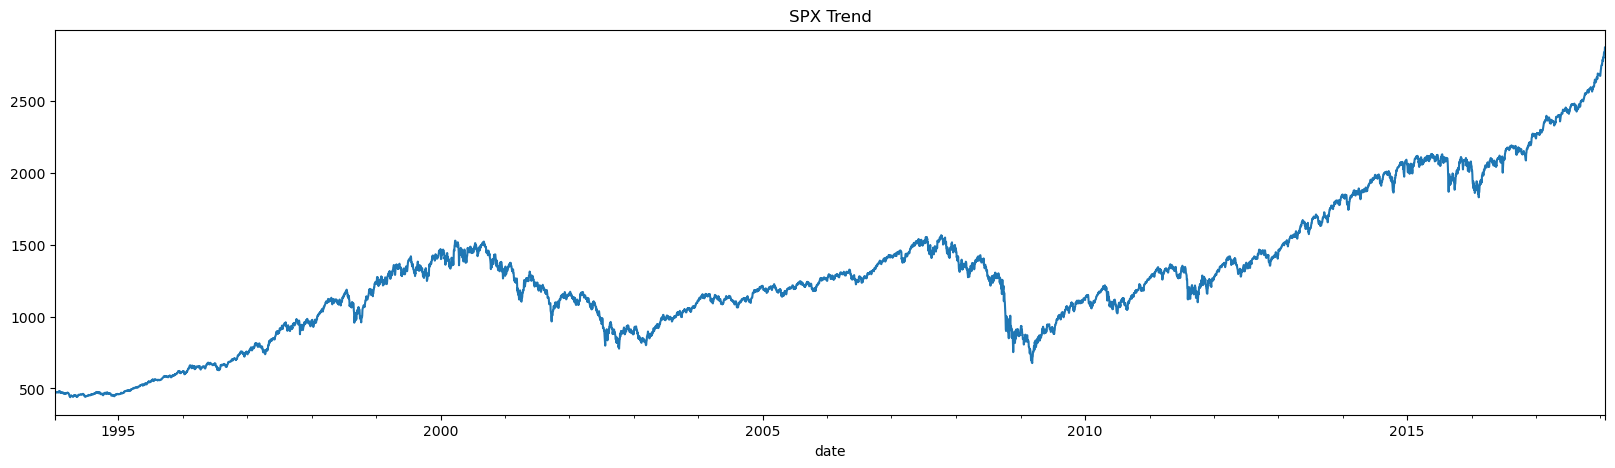

In [3]:
import matplotlib.pyplot as plt

df['spx'].plot(figsize=(20,5))
plt.title("SPX Trend")
plt.show()

To begin model fitting, let us look at ACF and PACF to determine the initial model orders

In [11]:
test_size = int(len(df)*0.8)

df_train = df.iloc[:test_size]
df_test = df.iloc[test_size:]

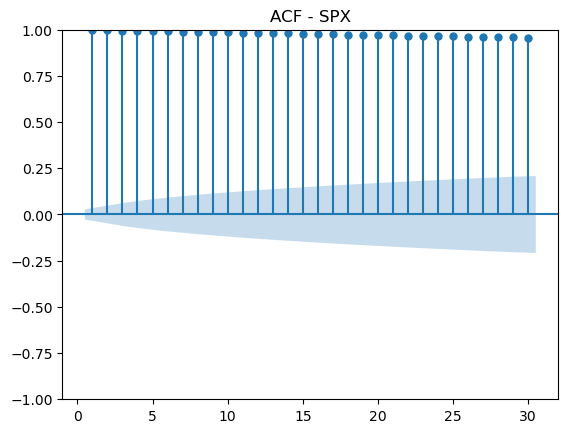

In [12]:
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt

sgt.plot_acf(df_train['spx'],lags = 30, zero=False ,title= 'ACF - SPX') # zero=False avoids plotting the zeroth lag
plt.show()

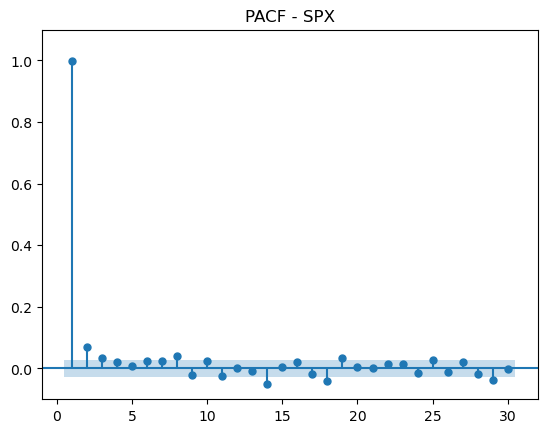

In [13]:
sgt.plot_pacf(df_train['spx'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,1.1)
plt.show()

The above `ACF` plot shows that the effects barely deteriorate over several lags. 

A `slow decaying ACF` could imply `Non-stationarity` which could be handled by transformations like differencing , using percentage change etc.,.

In [14]:
from statsmodels.tsa.stattools import adfuller

if adfuller(df_train['spx'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Non-Stationary


Let us use the `percentage change` calculation to force stationarity

In [15]:
df['returns'] = df['spx'].pct_change(1).mul(100)
df = df.iloc[1:]   # removing the NA resulting from percent change calculation

test_size = int(len(df)*0.8)

df_train = df.iloc[:test_size]
df_test = df.iloc[test_size:]

df_train.head(3)

,spx,dax,ftse,nikkei,returns
date,,,,,
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.239864
1994-01-12,474.17,2182.06,3372.02,18793.88,0.008437
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.358521


In [16]:
if adfuller(df_train['returns'])[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Stationary


As the data is stationary, let's examine the `ACF` and `PACF` to understand the lagged orders.

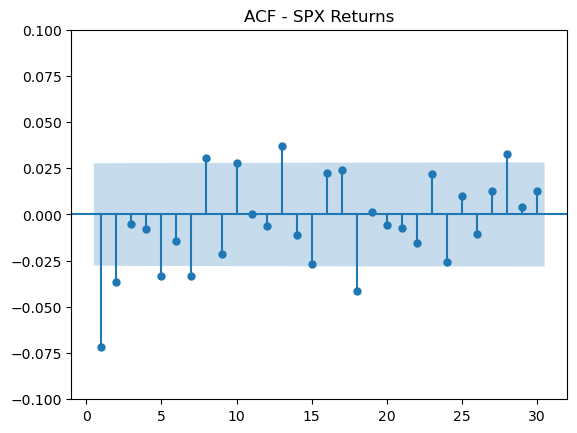

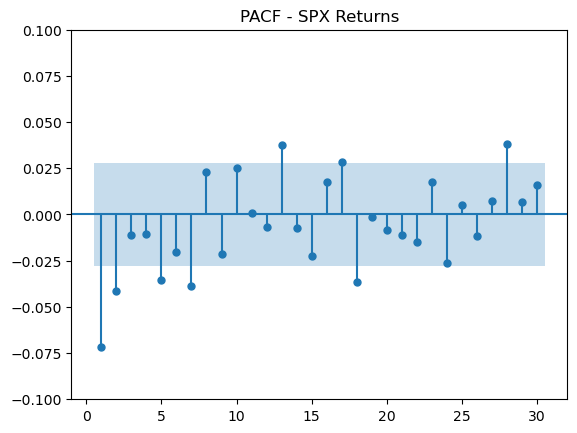

In [17]:
sgt.plot_acf(df_train['returns'],lags = 30, zero=False ,title= 'ACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

sgt.plot_pacf(df_train['returns'],lags = 30, zero=False,method=('ols'),title= 'PACF - SPX Returns') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.1,0.1)
plt.show()

As Moving Average model uses past error terms (not past values) to explain the current value. These error terms are uncorrelated by design, but their `linear combination` creates autocorrelation in the observed series. So we will look for these combinations of direct and indirect autocorrelation (can be provided by `ACF` plot) when we are modelling only through error terms.  
As we see atleast first 7 terms are significant based on `ACF`, let us create MA(1) to MA(7) and compare them.

**Note:** Though we see some significant correlation after 10 lags, since we expect the compound effects to decrease the further back in time we go, we can disregard the the latter lags.

In [71]:
from statsmodels.tsa.arima.model import ARIMA

for i in range(1,21):
    globals()['ma'+str(i)+'_ret'] = ARIMA(df_train['returns'],order=(0,0,i))  
    globals()['ma'+str(i)+'_ret_results'] = globals()['ma'+str(i)+'_ret'].fit()
    print('ma'+str(i)+'_ret model has',int((globals()['ma'+str(i)+'_ret_results'].pvalues[:-1] > 0.05).sum()),"(",round((int((globals()['ma'+str(i)+'_ret_results'].pvalues[:-1] > 0.05).sum())/(i+1))*100,1),"% )", 'non-significant co-efficients and llf is',round(globals()['ma'+str(i)+'_ret_results'].llf,1))

ma1_ret model has 1 ( 50.0 % ) non-significant co-efficients and llf is -8066.1
ma2_ret model has 0 ( 0.0 % ) non-significant co-efficients and llf is -8062.5
ma3_ret model has 1 ( 25.0 % ) non-significant co-efficients and llf is -8062.2
ma4_ret model has 2 ( 40.0 % ) non-significant co-efficients and llf is -8061.6
ma5_ret model has 2 ( 33.3 % ) non-significant co-efficients and llf is -8058.2
ma6_ret model has 2 ( 28.6 % ) non-significant co-efficients and llf is -8057.5
ma7_ret model has 3 ( 37.5 % ) non-significant co-efficients and llf is -8055.4
ma8_ret model has 3 ( 33.3 % ) non-significant co-efficients and llf is -8053.1
ma9_ret model has 3 ( 30.0 % ) non-significant co-efficients and llf is -8052.3
ma10_ret model has 2 ( 18.2 % ) non-significant co-efficients and llf is -8049.9
ma11_ret model has 3 ( 25.0 % ) non-significant co-efficients and llf is -8049.9
ma12_ret model has 4 ( 30.8 % ) non-significant co-efficients and llf is -8049.9
ma13_ret model has 5 ( 35.7 % ) non-si

Though log likelihood is steadily improving, we see some insifnificant co-efficients in higher order models. Let us perform Log-Likelihood Ratio(LLR) Test to see if the improvements in LLR are significant.

In [68]:
def LLR_test(model_simple,model_complex,dof=1):
    from scipy.stats import chi2
    L1 = model_simple.fit().llf
    L2 = model_complex.fit().llf
    LLR = (2*(L2-L1))
    p = chi2.sf(LLR,dof).round(3)
    return float(p)

In [72]:
for i in range(1,20):
    if LLR_test(globals()['ma'+str(i)+'_ret'],globals()['ma'+str(i+1)+'_ret'],1) <= 0.05:
        print('ma'+str(i+1)+'_ret is significant vs ma'+str(i)+'_ret')

ma2_ret is significant vs ma1_ret
ma5_ret is significant vs ma4_ret
ma7_ret is significant vs ma6_ret
ma8_ret is significant vs ma7_ret
ma10_ret is significant vs ma9_ret
ma13_ret is significant vs ma12_ret
ma15_ret is significant vs ma14_ret
ma18_ret is significant vs ma17_ret


All the models with more that 10 MA lags show more than 20% of co-efficients becoming non-significant, let us limit to 10 as the MA order.

Let us look at the resudials of all the models upto order 10

In [81]:
for i in range(1,11):
    print('ma'+str(i)+'_ret_results got residual mean of',round(globals()['ma'+str(i)+'_ret_results'].resid.mean(),5)," and variance of",round(globals()['ma'+str(i)+'_ret_results'].resid.var(),1))

ma1_ret_results got residual mean of 0.0  and variance of 1.5
ma2_ret_results got residual mean of -0.0  and variance of 1.5
ma3_ret_results got residual mean of -0.0  and variance of 1.5
ma4_ret_results got residual mean of -0.0  and variance of 1.5
ma5_ret_results got residual mean of -1e-05  and variance of 1.5
ma6_ret_results got residual mean of -1e-05  and variance of 1.5
ma7_ret_results got residual mean of -1e-05  and variance of 1.5
ma8_ret_results got residual mean of -1e-05  and variance of 1.4
ma9_ret_results got residual mean of -1e-05  and variance of 1.4
ma10_ret_results got residual mean of -1e-05  and variance of 1.4


As the model ma10_ret which is MA(10) has almost 0 mean and low variance, we can go ahead with it.

Let us look at the summary of MA(10) model and visualize the residuals.

In [82]:
ma10_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                ARIMA(0, 0, 10)   Log Likelihood               -8049.885
Date:                Mon, 01 Sep 2025   AIC                          16123.769
Time:                        19:08:45   BIC                          16202.023
Sample:                    01-11-1994   HQIC                         16151.191
                         - 04-08-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0311      0.016      1.999      0.046       0.001       0.061
ma.L1         -0.0754      0.009     -8.682      0.000      -0.092      -0.058
ma.L2         -0.0400      0.007     -5.734      0.000      -0.054      -0.026
ma.L3         -0.0082      0.009     -0.951      0.342      -0.025       0.009
ma.L4         -0.0091      0.008     -1.121      0.262      -0.025       0.007
ma.L5         -0.0358      0.008     -4.731      0.000      -0.051      -0.021
ma.L6         -0.0153      0.008     -1.963      0.050      -0.031   -2.11e-05
ma.L7         -0.0298      0.008     -3.893      0.000      -0.045      -0.015
ma.L8          0.0323      0.008      3.928      0.000       0.016       0.048
ma.L9         -0.0216      0.008     -2.870      0.004      -0.036      -0.007
ma.L10         0.0314      0.008      3.771      0.000       0.015       0.048
sigma2         1.4466      0.014    104.132      0.000       1.419       1.474
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13207.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

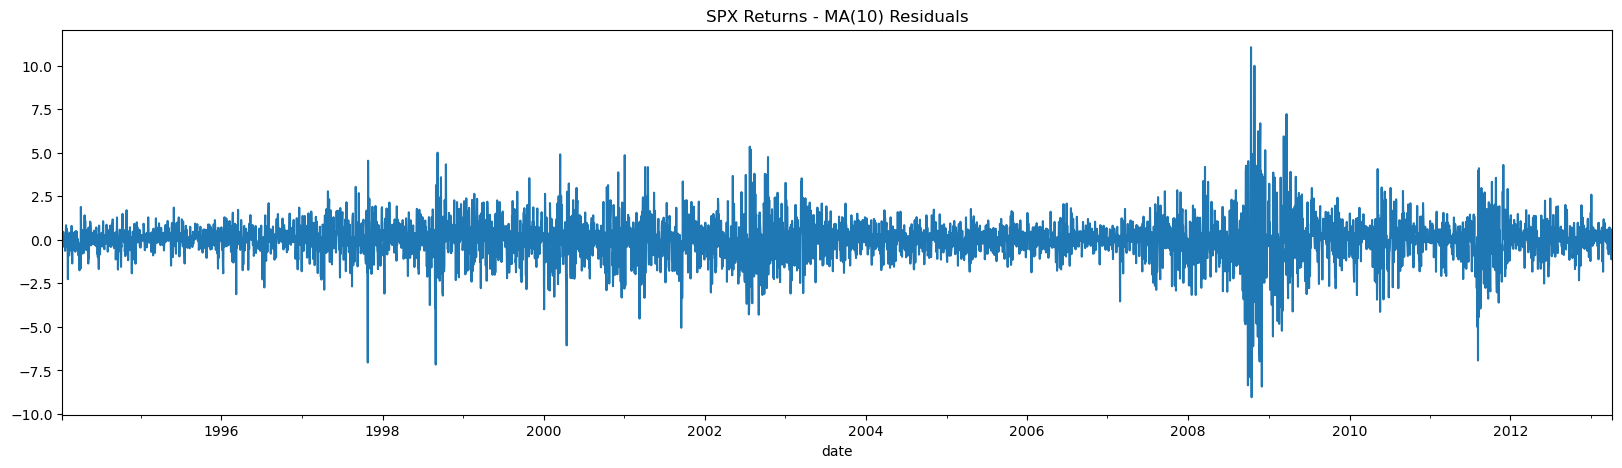

In [85]:
ma10_ret_results.resid.plot(figsize=(20,5))
plt.title("SPX Returns - MA(10) Residuals")
plt.show()

Analyze if resuduals resemble `white-noise` which is a form of `stationary` data

White noise should satisfy the below conditions  
`constant mean`  
`constant variance`  
`no autocorrelation`.

In [87]:
if adfuller(ma10_ret_results.resid)[1]<0.05:
    print("Stationary")
else:
    print("Non-Stationary")

Stationary


The resuduals are stationary. But stationary is not same as white noise. We should examine if there is any autocorrelation.

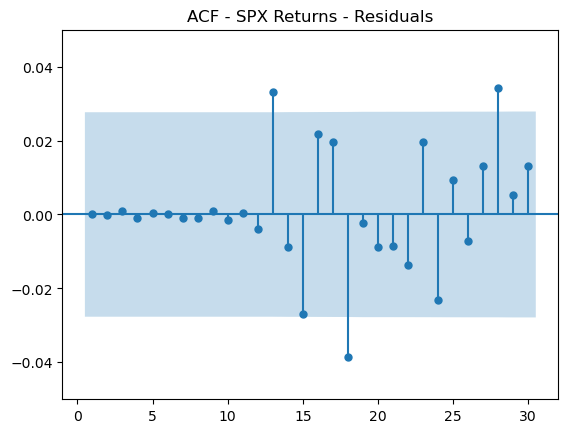

In [91]:
sgt.plot_acf(ma10_ret_results.resid,lags = 30, zero=False ,title= 'ACF - SPX Returns - Residuals') # zero=False avoids plotting the zeroth lag
plt.ylim(-0.05,0.05)
plt.show()

Since the first 10 lags are accounted in the model, those coefficients are essentially 0. As markets adjust for shocks, higher lags (i.e., values far in the past) lose relevance in current prediction. 

As we have used a number of lags in MA(10), it makes the model complex and increases the chances of `overfitting`. The model should be validated with test_set and optimized for low error rates in both test and train set.